In [1]:
from fastai.data.all import *
from fastai.vision.all import *
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.data.las import *
from enveco.model.ensemble import *
from enveco.interpretation import *
from enveco.model.alexnet import *
from enveco.metrics import *
from fastai.callback.progress import ShowGraphCallback

# Read data

Read field plot data used for training and validation

In [2]:
basedir = Path('../../../andras/ml/AV_leafon/')

train_df = pd.read_csv(basedir/'AV.leaf.on.train.csv')
valid_df = pd.read_csv(basedir/'AV.leaf.on.val.csv')
train_df['is_val'] = False
valid_df['is_val'] = True

df = pd.concat((train_df, valid_df))

df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v.ma,v.ku,v.lp,myear,filename.1,a.date.1,a.window.1,filename.2,a.date.2,a.window.2,v.lp.proc,is_val
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,False
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,False
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,False
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,False
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,False


Create `VoxelDataLoaders` from dataframe.

* `bin_voxels` controls whether to set all voxels to be either 0 or 1
* `mask_plot` controls whether to mask all locations outside 9m radius from center
* `bottom_voxels` controls whether to fill all voxels under any detected voxel

`DihedralItem` provides on-the-fly rotations as augmentations.

In [3]:
#export

class VoxelTo2D(Transform):
    "Transforms batch of 3D images to 2D images"
    order = 99
    
    def __init__(self, split_idx=None):
        super().__init__(split_idx=split_idx)
        
    def encodes(self, o:TensorImage):  
         return o[:,0]
    def decodes(self, o:TensorImage): 
         return o[:,None]

In [83]:
dls = VoxelDataLoaders.from_df(df, path=basedir, folder='AV_las/', 
                               bin_voxels=True, 
                               bottom_voxels=False, 
                               mask_plot=False,
                               y_block=RegressionBlock(), 
                               label_col='v', fn_col='sampleplotid', bs=32,
                               batch_tfms=[DihedralItem, VoxelTo2D])

In [84]:
dls.one_batch()

(VoxelImage size=32x105x40x40,
 tensor([ 39.5200, 169.9700, 388.4900,  50.1700,  92.5600, 123.9300,  39.4500,
         465.5300, 138.9000,  77.3500, 109.6200,  36.2500, 224.8600,  68.6600,
          74.5700,  38.7100, 126.6500,  50.4700,  80.1700, 115.5600, 108.6400,
         175.8600,  93.6900, 170.7300,  45.4100,  52.2100, 168.8000, 171.0300,
         334.9000,  54.8800, 108.2600, 312.2700], device='cuda:0'))

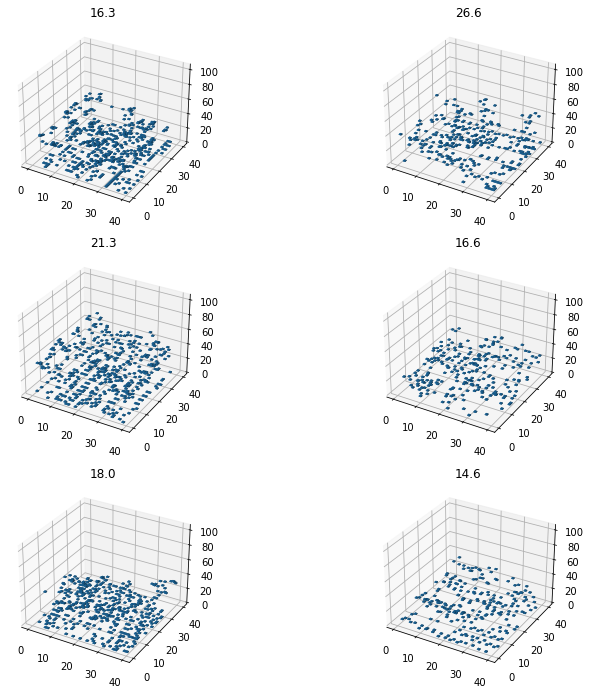

In [59]:
dls.show_batch()

# Learner

Set metrics to use

In [85]:
metrics = [rmse, rrmse, bias, bias_pct, mae, R2Score()]

Create learner

In [86]:
learn = alexnetvoxel_learner(dls, metrics=metrics, path='.', y_range=(0, train_df['v'].max()*1.1), n_in=105)

In [87]:
apply_init(learn.model)

In [88]:
learn.summary()

AlexNetVoxel (Input shape: ['32 x 105 x 40 x 40'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 1050 x 40 x 40  441,000    True      
________________________________________________________________
BatchNorm2d          32 x 1050 x 40 x 40  2,100      True      
________________________________________________________________
MaxPool2d            32 x 1050 x 20 x 20  0          False     
________________________________________________________________
Conv2d               32 x 256 x 20 x 20   2,419,200  True      
________________________________________________________________
BatchNorm2d          32 x 256 x 20 x 20   512        True      
________________________________________________________________
MaxPool2d            32 x 256 x 10 x 10   0          False     
________________________________________________________________
Conv2d               32 x 384 x 10 x 10   884,736    True      
_______________________________________________

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=9.12010818865383e-07)

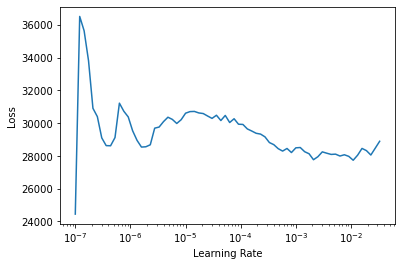

In [90]:
learn.lr_find()

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,26786.402344,43101.136719,207.608139,150.875595,-196.967239,-143.142502,196.967239,-6.814277,00:02
1,25195.169922,51629.828125,227.222000,165.129623,-224.309952,-163.013351,224.309967,-8.360537,00:02
2,24665.765625,21684.455078,147.256439,107.016052,-143.196350,-104.065445,143.342712,-2.931412,00:02
3,24123.871094,14377.451172,119.906013,87.139603,-114.616196,-83.295319,115.281586,-1.606646,00:02
4,23365.171875,17639.080078,132.812195,96.518944,-126.666679,-92.052795,127.496574,-2.197982,00:02
5,22710.359375,85538.914062,292.470367,212.547729,-288.693665,-209.803085,288.693695,-14.508286,00:02
6,18304.359375,5865.992676,76.589767,55.660278,-65.291176,-47.449223,70.183380,-0.063510,00:02
7,11460.529297,2879.150391,53.657715,38.994808,21.866222,15.890896,35.686741,0.478007,00:02
8,7416.833008,11899.522461,109.084930,79.275574,37.707561,27.403313,78.159241,-1.157395,00:02
9,5047.173828,6135.750488,78.331032,56.925709,65.438232,47.556095,70.003777,-0.112417,00:02


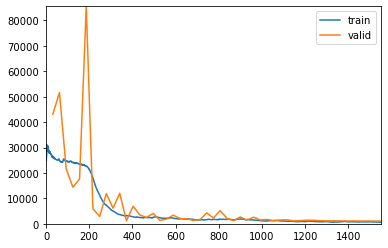

In [91]:
learn.fit_one_cycle(50, max_lr=1e-3, cbs=ShowGraphCallback())

# See results

In [92]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

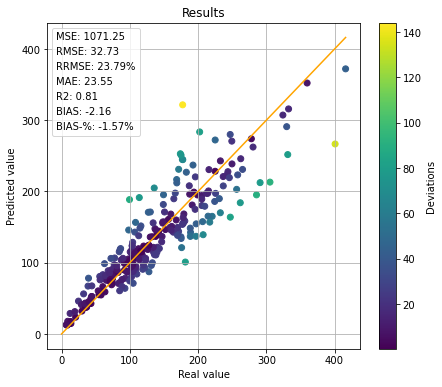

In [93]:
reg_interp.plot_results()
plt.show()

In [94]:
test_df = pd.read_csv(basedir/'AV.leaf.on.test.csv')

In [95]:
test_dl = learn.dls.test_dl(test_df, with_labels=True)


In [96]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dl)

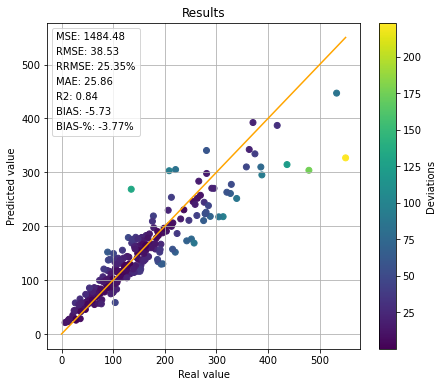

In [97]:
test_interp.plot_results()
plt.show()